# Forecast with a Deep Learning Network.
**Goal: Make a deep learning network similar to my [Bike-Sharing-Prediction project](https://github.com/viktor-begun/Deep_Learning_Bike_Sharing) and use it to forecast the price movement.**  

##  Load and prepare the data 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_path = 'EURUSD_1H_2016.txt'
df = pd.read_table(data_path,sep=',')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Local time  8783 non-null   object 
 1   Open        8783 non-null   float64
 2   High        8783 non-null   float64
 3   Low         8783 non-null   float64
 4   Close       8783 non-null   float64
 5   Volume      8783 non-null   float64
dtypes: float64(5), object(1)
memory usage: 411.8+ KB


In [4]:
df.head()

,Local time,Open,High,Low,Close,Volume
0,01.01.2016 00:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
1,01.01.2016 01:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
2,01.01.2016 02:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
3,01.01.2016 03:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
4,01.01.2016 04:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0


In [5]:
df.Low

0       1.08564
1       1.08564
2       1.08564
3       1.08564
4       1.08564
         ...   
8778    1.05150
8779    1.05150
8780    1.05150
8781    1.05150
8782    1.05150
Name: Low, Length: 8783, dtype: float64

**(!) Add a new column `High` minus `Low` - [`HML`](https://www.investopedia.com/terms/h/high_minus_low.asp)**

In [6]:
df['HML'] = df.High - df.Low

In [7]:
df.head()

,Local time,Open,High,Low,Close,Volume,HML
0,01.01.2016 00:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0,0.0
1,01.01.2016 01:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0,0.0
2,01.01.2016 02:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0,0.0
3,01.01.2016 03:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0,0.0
4,01.01.2016 04:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0,0.0


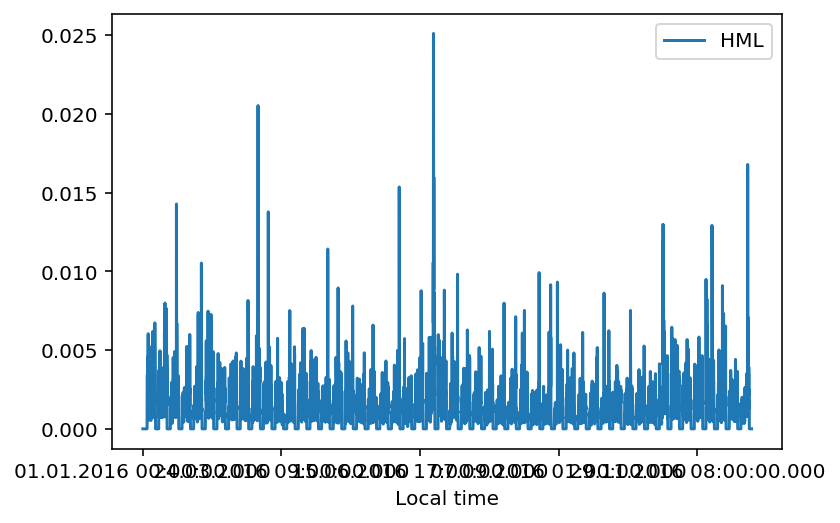

In [8]:
df.plot(x='Local time', y='HML');

## Dummy variables
We do not have dummy variables yet, but **we drop the `Local time`**, because it is a string, while our Neural Network accepts only numbers. It should be ok, because we keep the index, which can be used later to reconstruct the date and time. 

In [9]:
#dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
#for each in dummy_fields:
#    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
#    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['Local time']
df_no_time = df.drop(fields_to_drop, axis=1)
df_no_time.head()

,Open,High,Low,Close,Volume,HML
0,1.08564,1.08564,1.08564,1.08564,0.0,0.0
1,1.08564,1.08564,1.08564,1.08564,0.0,0.0
2,1.08564,1.08564,1.08564,1.08564,0.0,0.0
3,1.08564,1.08564,1.08564,1.08564,0.0,0.0
4,1.08564,1.08564,1.08564,1.08564,0.0,0.0


## Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [10]:
quant_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'HML']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = df_no_time[each].mean(), df_no_time[each].std()
    scaled_features[each] = [mean, std]
    df_no_time.loc[:, each] = (df_no_time[each] - mean)/std

df_no_time.head()

,Open,High,Low,Close,Volume,HML
0,-0.839744,-0.864742,-0.816484,-0.839569,-0.743981,-0.852004
1,-0.839744,-0.864742,-0.816484,-0.839569,-0.743981,-0.852004
2,-0.839744,-0.864742,-0.816484,-0.839569,-0.743981,-0.852004
3,-0.839744,-0.864742,-0.816484,-0.839569,-0.743981,-0.852004
4,-0.839744,-0.864742,-0.816484,-0.839569,-0.743981,-0.852004


## Splitting the data into training, testing, and validation sets.

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual values.

In [11]:
# Save data for approximately the last 21 days 
test_df = df_no_time[-21*24:]

# Now remove the test data from the data set 
df_no_time = df_no_time[:-21*24]

# Separate the data into features and targets
target_fields = ['HML', 'Volume']
features, targets = df_no_time.drop(target_fields, axis=1), df_no_time[target_fields]
test_features, test_targets = test_df.drop(target_fields, axis=1), test_df[target_fields]

In [12]:
targets.head()

,HML,Volume
0,-0.852004,-0.743981
1,-0.852004,-0.743981
2,-0.852004,-0.743981
3,-0.852004,-0.743981
4,-0.852004,-0.743981


In [13]:
features.head()

,Open,High,Low,Close
0,-0.839744,-0.864742,-0.816484,-0.839569
1,-0.839744,-0.864742,-0.816484,-0.839569
2,-0.839744,-0.864742,-0.816484,-0.839569
3,-0.839744,-0.864742,-0.816484,-0.839569
4,-0.839744,-0.864742,-0.816484,-0.839569


In [14]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [15]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8279 entries, 0 to 8278
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HML     8279 non-null   float64
 1   Volume  8279 non-null   float64
dtypes: float64(2)
memory usage: 129.5 KB


In [16]:
val_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 6839 to 8278
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HML     1440 non-null   float64
 1   Volume  1440 non-null   float64
dtypes: float64(2)
memory usage: 22.6 KB


In [17]:
from DL_Forecast_Network import NeuralNetwork

In [18]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests
Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [19]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'eurusd_1h_2016.txt') #'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(df, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)


.....
----------------------------------------------------------------------
Ran 5 tests in 0.010s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

In [20]:
batch = np.random.choice(train_features.index, size=128)
X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['HML']
print(X,y)

[[ 0.51323141  0.48940528  0.53509752  0.5131791 ]
 [ 0.6234827   0.64772895  0.61889798  0.60104585]
 [-0.94040789 -0.95389892 -0.98448424 -0.99173872]
 [ 0.5699549   0.55457386  0.57460345  0.55671308]
 [ 0.34985178  0.34427525  0.32519731  0.32746074]
 [ 0.6214854   0.59775305  0.64324002  0.62141496]
 [ 0.35025124  0.35666927  0.36869374  0.35981168]
 [ 0.30031859  0.31069144  0.32080776  0.33464984]
 [ 0.98020155  0.96277707  0.99240862  0.98326622]
 [ 0.61389563  0.6445305   0.63126853  0.64497923]
 [-1.27515637 -1.26774762 -1.26940581 -1.25334201]
 [ 0.26796224  0.25151996  0.25695978  0.24159096]
 [ 0.62747731  0.60375016  0.64922577  0.62740588]
 [ 1.19511168  1.17187627  1.21627558  1.19494522]
 [ 1.05170511  1.0799206   1.07261764  1.09190148]
 [ 0.02469037  0.00483888  0.02351563  0.0135368 ]
 [-0.80219431 -0.81556561 -0.79333937 -0.79763308]
 [ 0.90909746  0.89201119  0.90501671  0.90977767]
 [ 0.62747731  0.60375016  0.64922577  0.62740588]
 [ 0.42335264  0.39944865  0.44

In [24]:
import sys

####################
### Set the hyperparameters in you myanswers.py file ###
####################

#from my_answers import iterations, learning_rate, hidden_nodes, output_nodes
from DL_Forecast_Network import iterations, learning_rate, hidden_nodes, output_nodes


N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['HML']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['HML'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['HML'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.012 ... Validation loss: 0.036

iterations = 10000 learning_rate = 0.3 hidden_nodes = 30 output_nodes = 1
Training loss = 0.012438241531439314 
Validation loss = 0.036839481059135724


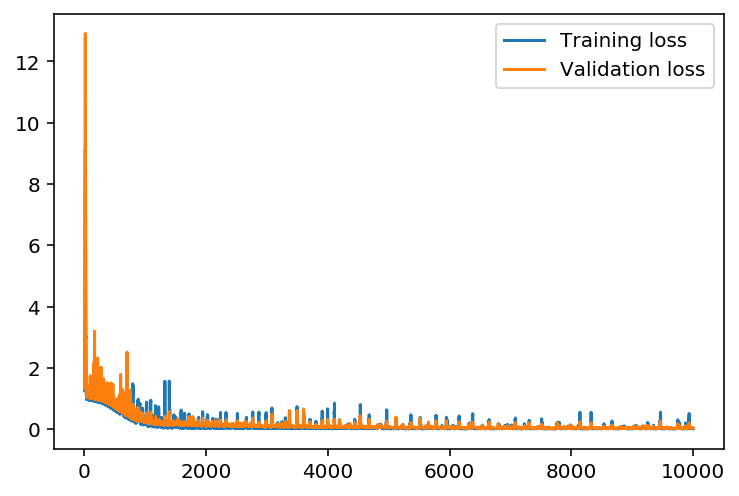

In [25]:
print('iterations =',iterations,'learning_rate =',learning_rate,'hidden_nodes =',hidden_nodes,'output_nodes =',output_nodes)
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()
print('Training loss =',losses['train'][-1],'\nValidation loss =',losses['validation'][-1])

## Check out the predictions

iterations = 10000 learning_rate = 0.3 hidden_nodes = 30 output_nodes = 1


/home/vb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


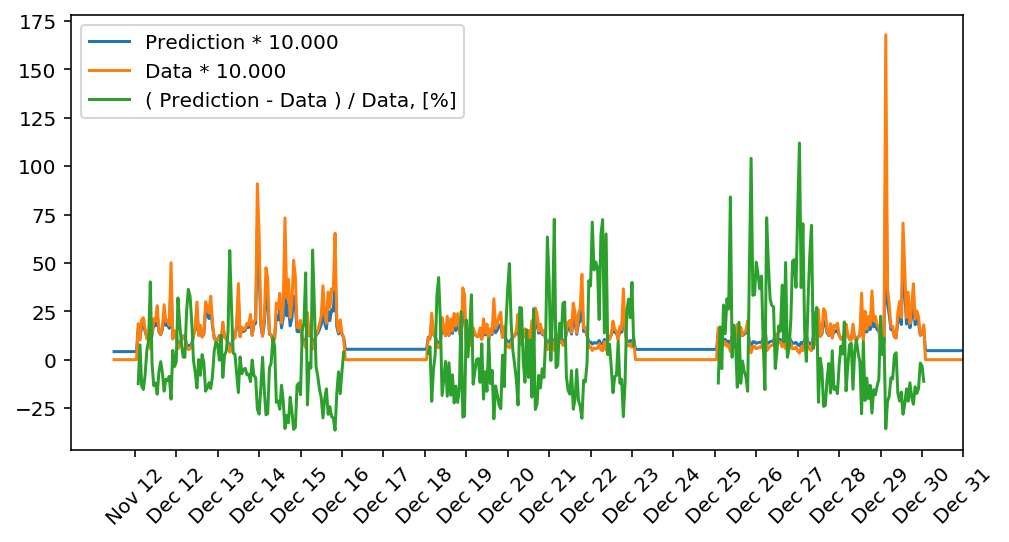

In [26]:
print('iterations =',iterations,'learning_rate =',learning_rate,'hidden_nodes =',hidden_nodes,'output_nodes =',output_nodes)

fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['HML']
predictions = network.run(test_features).T*std + mean
#ax.plot(predictions[0], label='Prediction')
#ax.plot((test_targets['HML']*std + mean).values, label='Data')
#
f1 = predictions[0]
f2 = (test_targets['HML']*std + mean).values
diff = 100*(f1 - f2) / f2
ax.plot(f1*10000, label='Prediction * 10.000')
ax.plot(f2*10000, label='Data * 10.000')
ax.plot(diff, label='( Prediction - Data ) / Data, [%]')
#

ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(df.iloc[test_df.index]['Local time'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)